# Rent the Runway: NLP

### Import Libraries and Data

In [16]:
#Data cleaning
import numpy as np
import pandas as pd

#NLP
import regex as re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')


#Modeling 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import svm

np.random.seed(42)

#Warnings - to keep the notebook clean 
import warnings 
warnings.filterwarnings('ignore')
pd.options.display.max_columns= 5000

In [17]:
#Import the cleaned file without dummy columns
df = pd.read_csv('./rent_the_runway_cleaned_no_dummies.csv')
df.head()

,age,body_type,bust_size,category,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight
0,36,hourglass,34d,dress,1,5. 5,815826,10,wedding,2017-09-18,"Good fit, great style, comfortable yet elegant",Rented for early brunch/garden wedding. My to...,20,334577,137
1,34,athletic,34c,dress,1,5. 5,1636171,10,work,2017-04-19,Love the fit and fabric!,This dress was perfect. The fabric is thick an...,8,634115,125
2,30,hourglass,34a,gown,0,5. 8,438881,10,formal affair,2017-10-18,"Simple black dress, loved the ruffles.",Wore this dress to a Naval Ball. The dress did...,13,988705,124
3,32,hourglass,34d,dress,1,5. 8,1392841,10,wedding,2017-08-07,One of my fav rentals,Loved this fun dress. The low V in the front m...,16,977884,158
4,34,pear,34a,dress,2,5. 7,160612,8,party,2015-01-05,Pretty but not meant for small chested girls,"Pretty dress, but I didn't have the bust to fi...",8,795673,135


In [18]:
#Drop the null values 
df.dropna(inplace=True)
    
#Trim the dataframe to only be text columns 
df= df[['fit', 'review_summary', 'review_text']]

In [19]:
df.shape

(29237, 3)

In [20]:
df.head()

,fit,review_summary,review_text
0,1,"Good fit, great style, comfortable yet elegant",Rented for early brunch/garden wedding. My to...
1,1,Love the fit and fabric!,This dress was perfect. The fabric is thick an...
2,0,"Simple black dress, loved the ruffles.",Wore this dress to a Naval Ball. The dress did...
3,1,One of my fav rentals,Loved this fun dress. The low V in the front m...
4,2,Pretty but not meant for small chested girls,"Pretty dress, but I didn't have the bust to fi..."


# NLP Pre-processing 

Since the results of the model are not so great, let's incorporate NLP on the review text. 

In [21]:
#Function to clean the text data 

def clean_text(df):

    df['full_review'] = df['review_summary'] + ' ' + df['review_text']                 
    #Combine selftext & title into one column 
    
    df['full_review'] = [str(words).lower() for words in df['full_review']]    
    #Change all the text to lowercase 
    
    df['full_review'] = [(re.sub(r'[^\w\s]','', word)) for word in df['full_review']]
    #remove puncutation. Got this regex code from stack overflow, checked it in regex101.com and put it in a list comp
    
    df['full_review'] = [(re.sub('[^A-Za-z]+', ' ', text)) for text in df['full_review']]
    #remove numbers
    
    return df

In [22]:
clean_text(df)

,fit,review_summary,review_text,full_review
0,1,"Good fit, great style, comfortable yet elegant",Rented for early brunch/garden wedding. My to...,good fit great style comfortable yet elegant r...
1,1,Love the fit and fabric!,This dress was perfect. The fabric is thick an...,love the fit and fabric this dress was perfect...
2,0,"Simple black dress, loved the ruffles.",Wore this dress to a Naval Ball. The dress did...,simple black dress loved the ruffles wore this...
3,1,One of my fav rentals,Loved this fun dress. The low V in the front m...,one of my fav rentals loved this fun dress the...
4,2,Pretty but not meant for small chested girls,"Pretty dress, but I didn't have the bust to fi...",pretty but not meant for small chested girls p...
5,1,"Amazing fit, beautiful material, a little sexy...",This dress was perfect. I felt so good in it....,amazing fit beautiful material a little sexy l...
6,1,Great summer wedding pick!,I loved this dress! I run between a 12 and a 1...,great summer wedding pick i loved this dress i...
7,1,The perfect dress for a sparkly Broadway openi...,This dress is perfect. I don't think I've ever...,the perfect dress for a sparkly broadway openi...
8,2,Tons of Compliments!,I wore this for my bridal shower at a Country ...,tons of compliments i wore this for my bridal ...
9,1,Rented this dress for my brother's wedding.,An excellent dress. Would definitely rent aga...,rented this dress for my brothers wedding an e...


In [23]:
#Lemmatize
lm= WordNetLemmatizer()

df['full_review'] = [" ".join([lm.lemmatize(w) for w in i.split()]) for i in df['full_review']]

In [24]:
#Check that the lemmatizer worked 
df[['full_review']].head()

,full_review
0,good fit great style comfortable yet elegant r...
1,love the fit and fabric this dress wa perfect ...
2,simple black dress loved the ruffle wore this ...
3,one of my fav rental loved this fun dress the ...
4,pretty but not meant for small chested girl pr...


In [25]:
#Export the combined and cleaned text column 
text = df[['full_review']]
text.to_csv('./rent_the_runway_text.csv', index=False)

# NLP Modeling

In [26]:
#Declare X and y 

X = df['full_review']
y = df['fit']

In [27]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state =42, 
                                                    stratify = y)

In [28]:
#Function to run various models 

def fit_and_evaluate(X, y, 
                     vect_name = 'tfidf',
                     vect_type = TfidfVectorizer(),
                     model_name = 'logreg', 
                     model_type = LogisticRegression()):
    
    pipe = Pipeline([
        (vect_name, vect_type),
        (model_name, model_type)
    ])
    
    model = pipe.fit(X, y)
    
    score = model.score(X,y)
    
    # Print attributes
    
    print(f"Score: {score}")
    
    return model

In [29]:
#Tfidf & Logistic Regression

fit_and_evaluate(X_train, y_train, 
                 vect_name='tfidf', 
                 vect_type=TfidfVectorizer(),
                 model_name='logreg', 
                 model_type=LogisticRegression())

fit_and_evaluate(X_test, y_test, 
                 vect_name='tfidf', 
                 vect_type=TfidfVectorizer(),
                 model_name='logreg', 
                 model_type=LogisticRegression())

Score: 0.8216354266429516
Score: 0.8125854993160054


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [30]:
#Cvec& Logistic Regression

fit_and_evaluate(X_train, y_train, 
                 vect_name='cvec', 
                 vect_type=CountVectorizer(),
                 model_name='logreg', 
                 model_type=LogisticRegression())

fit_and_evaluate(X_test, y_test, 
                 vect_name='cvec', 
                 vect_type=CountVectorizer(),
                 model_name='logreg', 
                 model_type=LogisticRegression())

Score: 0.8854836502941579
Score: 0.9255813953488372


Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [31]:
#Tfidf & Naive Bayes

fit_and_evaluate(X_train, y_train, 
                 vect_name='tfidf', 
                 vect_type=TfidfVectorizer(),
                 model_name='nb', 
                 model_type=MultinomialNB())

fit_and_evaluate(X_test, y_test, 
                 vect_name='tfidf', 
                 vect_type=TfidfVectorizer(),
                 model_name='nb', 
                 model_type=MultinomialNB())

Score: 0.7362612304464815
Score: 0.7365253077975377


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [32]:
#Cvec & Naive Bayes

fit_and_evaluate(X_train, y_train, 
                 vect_name='cvec', 
                 vect_type=CountVectorizer(),
                 model_name='nb', 
                 model_type=MultinomialNB())

fit_and_evaluate(X_test, y_test, 
                 vect_name='cvec', 
                 vect_type=CountVectorizer(),
                 model_name='nb', 
                 model_type=MultinomialNB())

Score: 0.8302093309618279
Score: 0.8400820793433652


Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [33]:
#Tfidf & KNN
#Overfit 

fit_and_evaluate(X_train, y_train, 
                 vect_name='tfidf', 
                 vect_type=TfidfVectorizer(),
                 model_name='knn', 
                 model_type=KNeighborsClassifier())

fit_and_evaluate(X_test, y_test, 
                 vect_name='tfidf', 
                 vect_type=TfidfVectorizer(),
                 model_name='knn', 
                 model_type=KNeighborsClassifier())

Score: 0.7375381949195057
Score: 0.8170998632010944


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

In [34]:
#Cvec & KNN

fit_and_evaluate(X_train, y_train, 
                 vect_name='cvec', 
                 vect_type=CountVectorizer(),
                 model_name='knn', 
                 model_type=KNeighborsClassifier())

fit_and_evaluate(X_test, y_test, 
                 vect_name='cvec', 
                 vect_type=CountVectorizer(),
                 model_name='knn', 
                 model_type=KNeighborsClassifier())

Score: 0.7715145710767547
Score: 0.774829001367989


Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

In [35]:
#Tfidf & Random Forests 

rf_tfidf = fit_and_evaluate(X_train, y_train, 
                 vect_name='tfidf', 
                 vect_type=TfidfVectorizer(),
                 model_name='rf', 
                 model_type=RandomForestClassifier())

fit_and_evaluate(X_test, y_test, 
                 vect_name='tfidf', 
                 vect_type=TfidfVectorizer(),
                 model_name='rf', 
                 model_type=RandomForestClassifier())

Score: 0.9836274912208692
Score: 0.9842681258549931


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [36]:
#Cvec & Random Forests 

rf_cvec = fit_and_evaluate(X_train, y_train, 
                 vect_name='cvec', 
                 vect_type=CountVectorizer(),
                 model_name='rf', 
                 model_type=RandomForestClassifier())

fit_and_evaluate(X_test, y_test, 
                 vect_name='cvec', 
                 vect_type=CountVectorizer(),
                 model_name='rf', 
                 model_type=RandomForestClassifier())

Score: 0.9854517261823322
Score: 0.9842681258549931


Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

# Evaluate Results

The scores for Random Forests were best. The Count Vectorizer & Tfidf Vectorizer resulted in nearly the same scores. However, the Cvec model is slightly less overfit, which means less misclassifications. 

In [37]:
#Predictions 
predictions = rf_cvec.predict(X_test)

# Create DataFrame with column for predicted values
results = pd.DataFrame({'predicted': predictions, 
                        'actual': y_test})

#Find the rows with incorrect predictions 
misclass = results[results['predicted'] != results['actual']]
print(misclass.shape)
misclass.head()

(1760, 2)


,predicted,actual
10695,1,0
17615,1,2
15088,0,2
28465,1,0
25157,1,2


In [38]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, 
                 predictions) 

#Here we can see the misclassified predictions 

array([[ 165,  804,   12],
       [  78, 5258,   45],
       [  43,  778,  127]])

In [39]:
#Example of misclassified review 
df[df.index == 10695]

,fit,review_summary,review_text,full_review
10695,0,Unusual in a good way and a lovely plum color....,My original dress choice ended up not being av...,unusual in a good way and a lovely plum color ...


In [40]:
df['full_review'].loc[10695]

'unusual in a good way and a lovely plum color comfortable to wear my original dress choice ended up not being available rtr sent me an email that allowed me to make several more choice at any price wasnt sure i would like this one but it wa a really pretty plum color and the neckline wa unusual and looked great on length wa perfect for me with lower heel material wa heavier perfect for the winter formal that i attended run a little on the small side of you have a larger ribcage like i do no stretch wore it with a strapless bra received many compliment from complete stranger rent this if you want something different than the typical lbd for an evening formal event'

In [41]:
def get_top_n_words(corpus, n=None):                                            
#     List the top n words in a vocabulary according to occurrence in a text corpus.
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [42]:
#Apply the function to the data 

top_words = get_top_n_words(df['full_review'], n=None)

top_ten_words = pd.DataFrame(top_words[:10], columns={'word', 'count'})

top_ten_words

,word,count
0,dress,52690
1,wa,48493
2,fit,17632
3,size,13030
4,great,11821
5,perfect,11169
6,wore,10674
7,wear,10609
8,compliment,9785
9,comfortable,9251


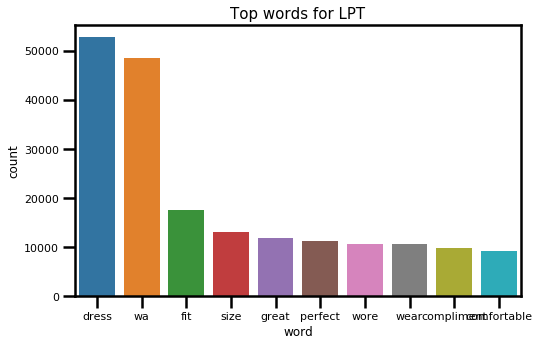

In [44]:
#Plot the top words 

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8, 5))
sns.set_context("poster", font_scale = .5)
plt.title('Top words for LPT', fontsize = 15)
sns.barplot(x='word', y ='count', data = top_ten_words );